In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Загрузим данные из файла в объект DataFrame и установим имя столбца 'Nums'
df = pd.read_csv('1.txt', header=None)
df.columns = ['Nums']

In [3]:
# Отображение сводной статистики по данным
df.describe()

,Nums
count,32.000000
mean,5.279325
std,4.131237
min,-2.079015
25%,2.595951
50%,5.176874
75%,7.591765
max,17.141189


In [4]:
# Определение функции для вычисления интервальных данных
def interval(df):
    height = df.Nums
    # m = round(1 + np.log2(len(height)))  # Вычисление количества интервалов 'm'
    # h = (np.max(height) - np.min(height)) / m  # Вычисление ширины интервала 'h'
    m = round(1 + 3.322 * np.log10(len(height)) )  # Увеличено количество интервалов
    h = (np.max(height) - np.min(height)) / m  # Изменено начальное значение h

    interval = [np.min(height) - 0.01]  # Инициализация списка интервалов
    for k in range(1, m + 2):
        interval = np.append(interval, interval[k - 1] + h)  # Генерация интервалов
    interval_1 = interval[1::]  # Верхние границы интервалов
    interval_2 = interval[:-1]  # Нижние границы интервалов
    height = sorted(height)  # Сортировка данных
    abs_freq_var = [0] * (m + 1)  # Инициализация списка абсолютных частот
    i = 0
    for k in range(len(height)):
        for j in range(len(interval_1)):
            if (height[k] > interval_2[j] and height[k] < interval_1[j]):
                abs_freq_var[j] += 1  # Вычисление абсолютных частот для каждого интервала

    var_series_2 = pd.DataFrame([interval_2, interval_1])  # Создание DataFrame для интервалов
    rel_freq_var = np.array(abs_freq_var) / len(df)  # Вычисление относительных частот
    var_series_2 = var_series_2.T  # Транспонирование DataFrame
    var_series_2.columns = ['left', 'right']
    var_series_2 = var_series_2.join(
        [pd.Series(abs_freq_var, name='abs_freq').T, pd.Series(rel_freq_var, name='rel_freq').T])  # Добавление столбцов
    return var_series_2, interval_1, interval_2, h

In [5]:
# Вычисление интервальных данных
var, int1, int2, h = interval(df)

In [6]:
var

,left,right,abs_freq,rel_freq
0,-2.089015,1.114353,5,0.15625
1,1.114353,4.317720,9,0.28125
2,4.317720,7.521087,10,0.31250
3,7.521087,10.724455,6,0.18750
4,10.724455,13.927822,1,0.03125
5,13.927822,17.131189,0,0.00000
6,17.131189,20.334557,1,0.03125


In [7]:
# Подготовка меток интервалов для гистограммы
interval_hist = list(map(str, np.array([x for x in zip(int2.round(2), int1.round(2))])))
interval_hist = [x.replace(']', '') for x in interval_hist]
interval_hist = [x.replace('[', '') for x in interval_hist]

<BarContainer object of 7 artists>

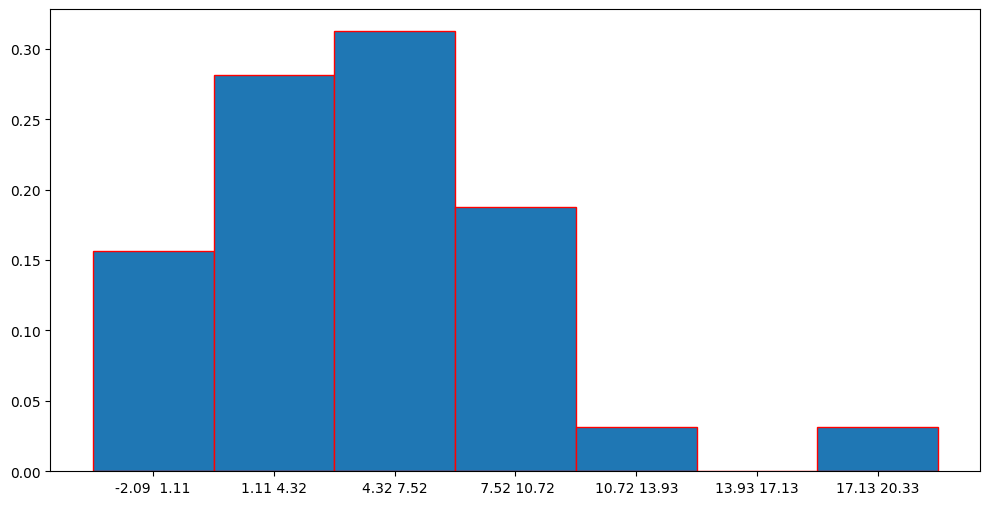

In [8]:
# Создание гистограммы
plt.figure(figsize = (12, 6))
plt.bar(int1, var['rel_freq'], width=h, edgecolor = 'r', tick_label = interval_hist)

In [13]:
# Функция для проверки нормальности с использованием критерия Пирсона
# def chi2_pearson_norm(df1, df2):
  # mean = df1.Nums.describe()['mean']
  # std = df1.Nums.describe()['std']
  # df2['Pi'] = (stats.norm.cdf((df2['right']-mean)/std) - 0.5 - (stats.norm.cdf((df2['left']-mean)/std) - 0.5))*len(df)
  # chi2 = (((df2['abs_freq'] - df2['Pi'])**2)/df2['Pi']).sum()
  # if chi2 < stats.chi2.ppf(0.95, len(df2) - 3):
  #   return 'norm', df2, chi2, stats.chi2.ppf(0.95, len(df2) - 3)
  # else:
  #   return 'not norm'


def chi2_pearson_norm(df1, df2):
    # Рассчитываем среднее значение и стандартное отклонение данных
    mean = df1.Nums.describe()['mean']
    std = df1.Nums.describe()['std']
    
    # Рассчитываем ожидаемые частоты (Pi) для каждого интервала
    df2['Pi'] = (stats.norm.cdf((df2['right'] - mean) / std) - 0.5 - (
                stats.norm.cdf((df2['left'] - mean) / std) - 0.5)) * len(df1)
    
    # Рассчитываем значение статистики хи-квадрат
    chi2 = (((df2['abs_freq'] - df2['Pi']) ** 2) / df2['Pi']).sum()
    
    # Проверяем, является ли значение статистики хи-квадрат меньше критического значения
    if chi2 < stats.chi2.ppf(0.95, len(df2) - 3):
        return 'norm', df2, chi2, stats.chi2.ppf(0.95, len(df2) - 3)
    else:
        return 'not norm'


In [14]:
# Функция для проверки экспоненциального распределения с использованием критерия Пирсона
def chi2_pearson_exp(df1, df2):
  mean = df1.Nums.describe()['mean']
  lambda_ = 1/mean
  df2['Pi'] = (np.exp((-1)*lambda_*df2['left']) - np.exp((-1)*lambda_*df2['right']))*len(df1)
  chi2 = (((df2['abs_freq'] - df2['Pi'])**2)/abs(df2['Pi'])).sum()
  if chi2 < stats.chi2.ppf(0.95, len(df2) - 2):
    return 'exp', df2, chi2, stats.chi2.ppf(0.95, len(df2) - 2)
  else:
    return 'not exp'

In [15]:
# Проверка на экспоненциальное распределение с использованием определенной функции
chi2_pearson_exp(df, var)

'not exp'

In [16]:
# Проверка на нормальность с использованием определенной функции
chi2_pearson_norm(df, var)

'not norm'

In [13]:
# Фильтрация интервалов с нулевыми абсолютными частотами
var_new = var[var['abs_freq'] != 0]

In [14]:
# Создание DataFrame для натуральных логарифмов относительных частот
anamorf = pd.DataFrame(np.log(var_new['rel_freq']))

In [15]:
anamorf['mean_int'] = ((var['right'] + var['left'])/2)
anamorf['x'] = (anamorf['mean_int'] - df['Nums'].mean())**2
anamorf

,rel_freq,mean_int,x
0,-1.856298,-0.487331,33.254320
1,-1.268511,2.716036,6.570448
2,-1.163151,5.919404,0.409701
3,-1.673976,9.122771,14.772079
4,-3.465736,12.326138,49.657581
6,-3.465736,18.732873,180.997960


In [16]:
# Подготовка данных для регрессионного анализа
X = np.array(anamorf['x'])
y = np.array(anamorf['rel_freq'])
X_1 = np.array(anamorf['mean_int'])

In [17]:
X_new = np.c_[X, np.ones(np.shape(X)[0])]
X_new_1 = np.c_[X_1, np.ones(np.shape(X_1)[0])]

In [18]:
from sklearn.metrics import r2_score

In [19]:
# Расчет коэффициентов регрессии для нормального распределения
W_1 = np.linalg.inv(X_new.T @ X_new) @ X_new.T @ y
# Расчет коэффициентов регрессии для экспоненциального распределения
W_2 = np.linalg.inv(X_new_1.T @ X_new_1) @ X_new_1.T @ y

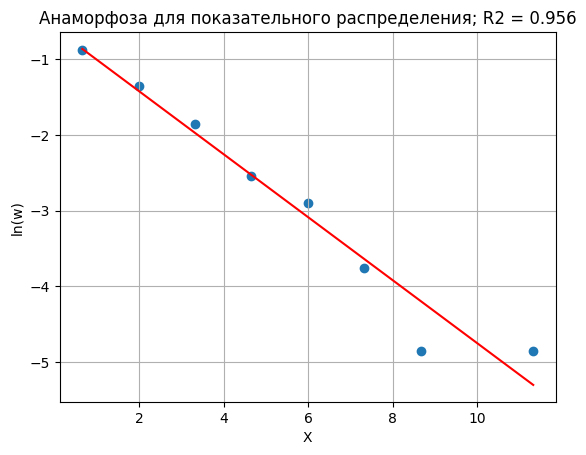

<Figure size 500x500 with 0 Axes>

In [20]:
# Построение графика регрессии для показательного распределения
fig, ax = plt.subplots()
plt.figure(figsize=(5,5))
ax.grid()
ax.scatter(X_1,y)
ax.plot(X_1, X_new_1@W_2,color='r')
ax.set_xlabel("X")
ax.set_ylabel("ln(w)")
ax.set_title(f'Анаморфоза для показательного распределения; R2 = {r2_score(y, X_new_1@W_2).round(3)}')
plt.show()

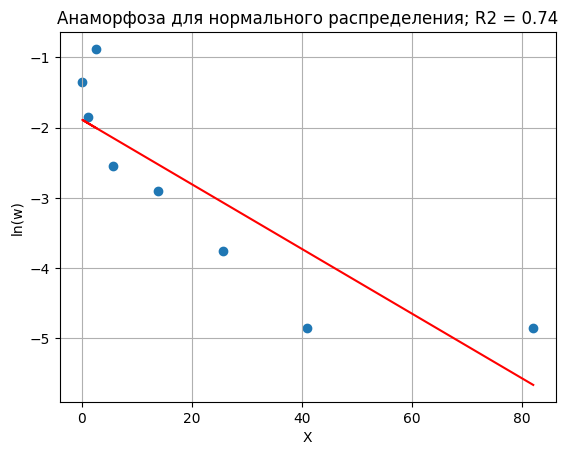

<Figure size 500x500 with 0 Axes>

In [21]:
# Построение графика регрессии для нормального распределения
fig, ax = plt.subplots()
plt.figure(figsize=(5,5))
ax.grid()
ax.scatter(X,y)
ax.plot(X, X_new@W_1,color='r')
ax.set_xlabel("X")
ax.set_ylabel("ln(w)")
ax.set_title(f'Анаморфоза для нормального распределения; R2 = {r2_score(y, X_new@W_1).round(3)}')
plt.show()

In [22]:
W_1[1]

-1.8876330093086626

In [23]:
# Расчет и отображение стандартного отклонения для нормального распределения
print("std =", np.sqrt(-1/(2*W_1[0])))

std = 3.296476242410818


In [24]:
# Расчет и отображение параметра λ для экспоненциального распределения
print("lambda =", -1/W_2[0])

lambda = 2.406092444829821


In [25]:
6.137134296670262
5.0600282499059235
7.915783805274179
11.906272763737153
3.8895282379042886

3.8895282379042886